<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems

# Jacobi method

## Contents

In this notebook, we will learn

- How to paralleize a Jacobi method
- How the data partition can impact the performance of a distributed algorithm
- How to use latency hiding



## The Jacobi method


The [Jacobi method](https://en.wikipedia.org/wiki/Jacobi_method) is a numerical tool to solve systems of linear algebraic equations. One of the main applications of the method is to solve boundary value problems (BVPs). I.e., given the values at the boundary (of a grid), the Jacoby method will find the interior values that fulfill a certain equation.



<div>
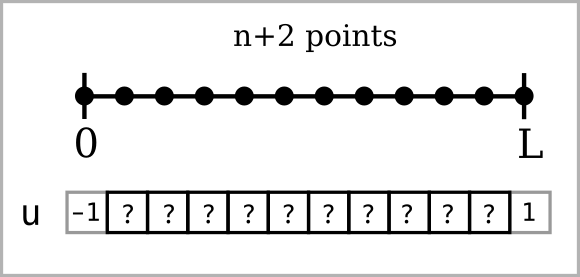
</div>

### Serial implementation

In [ ]:
function jacobi(n,niters)
    u = zeros(n+2)
    u[1] = -1
    u[end] = 1
    u_new = copy(u)
    for t in 1:niters
        for i in 2:(n+1)
            u_new[i] = 0.5*(u[i-1]+u[i+1])
        end
        u, u_new = u_new, u
    end
    u
end

In [ ]:
jacobi(5,1000)

<div class="alert alert-block alert-info">
<b>Note:</b> The values computed by the Jacobi method are linearly increasing from -1 to 1. It is possible to show mathematically that the method we implemented in the function above approximates a 1D Laplace equation via a finite difference method and the solution of this equation in this setup is a linear function.
</div>

<div class="alert alert-block alert-info">
<b>Note:</b> In our version of the jacobi method, we return after a given number of iterations. Other stopping criteria are possible. For instance, iterate until the difference between u and u_new is below a tolerance. 
</div>


### Where do we can exploit parallelism?

Look at the two nested loops in the sequential implementation:

```julia
for t in 1:nsteps
    for i in 2:(n+1)
        u_new[i] = 0.5*(u[i-1]+u[i+1])
    end
    u, u_new = u_new, u
end
```

- The outer loop cannot be parallelized. The value of `u` at step `t+1` depends on the value at the previous step `t`.
- The inner loop can be parallelized



### The Gauss-Seidel method

The usage of `u_new` seems a bit unnecessary at first sight, right?. If we remove it, we get another method called Gauss-Seidel.



In [ ]:
function gauss_seidel(n,nsteps)
    u = zeros(n+2)
    u[1] = -1
    u[end] = 1
    for t in 1:nsteps
        for i in 2:(n+1)
            u[i] = 0.5*(u[i-1]+u[i+1])
        end
    end
    u
end

Note that the final solution is the same (up to machine precision).

In [ ]:
gauss_seidel(5,1000)

<div class="alert alert-block alert-success">
<b>Question:</b>  Which of the two loops in the Gauss-Seidel method are trivially parallelizable?
</div>

```julia
for t in 1:nsteps
    for i in 2:(n+1)
        u[i] = 0.5*(u[i-1]+u[i+1])
    end
end
```

    a) Both of them
    b) The outer, but not the inner
    c) None of them
    d) The inner, but not the outer


In [ ]:
#TODO answer (c)

## Parallelization of the Jacobi method



### Parallelization strategy

- Each worker updates a consecutive section of the array `u_new` 



### Data dependencies

Recall:

`u_new[i] = 0.5*(u[i-1]+u[i+1])`


Thus, each process will need values from the neighboring processes to perform the update of its boundary values.

<div>
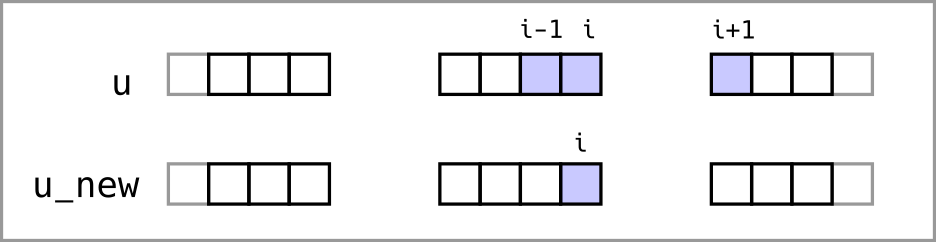
</div>

### Ghost cells

A usual way of handling this type of data dependencies is using so-called ghost cells. Ghost cells represent the missing data dependencies in the data owned by each process. After importing the appropriate values from the neighbor processes one can perform the usual sequential jacoby update locally in the processes.

<div>
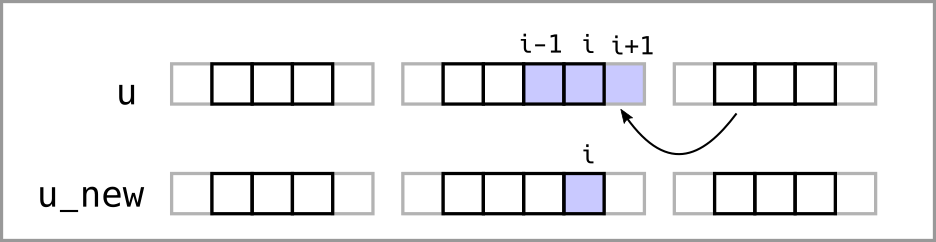
</div>

<div class="alert alert-block alert-success">
<b>Question:</b>  Which is the communication and computation complexity in each process? N is the length of the vector and P the number of processes.    
</div>

In [ ]:
#TODO

## Implementation

In [ ]:
] add MPI MPIClusterManagers

In [ ]:
using MPIClusterManagers
using Distributed

In [ ]:
if procs() == workers()
    nw = 3
    manager = MPIWorkerManager(nw)
    addprocs(manager)
end

In [ ]:
@everywhere workers() begin
    using MPI
    MPI.Initialized() && MPI.Init()
    comm = MPI.Comm_dup(MPI.COMM_WORLD)
    nw = MPI.Comm_size(comm)
    iw = MPI.Comm_rank(comm)+1
    function jacobi_mpi(n,niters)
        if mod(n,nw) != 0
            println("n must be a multiple of nw")
            MPI.Abort(comm,1)
        end
        n_own = div(n,nw)
        u = zeros(n_own+2)
        u[1] = -1
        u[end] = 1
        u_new = copy(u)
        for t in 1:niters
            reqs = MPI.Request[]
            if iw != 1
                neig_rank = (iw-1)-1
                req = MPI.Isend(view(u,2:2),comm,dest=neig_rank,tag=0)
                push!(reqs,req)
                req = MPI.Irecv!(view(u,1:1),comm,source=neig_rank,tag=0)
                push!(reqs,req)
            end
            if iw != nw
                neig_rank = (iw+1)-1
                s = n_own-1
                r = n_own
                req = MPI.Isend(view(u,s:s),comm,dest=neig_rank,tag=0)
                push!(reqs,req)
                req = MPI.Irecv!(view(u,r:r),comm,source=neig_rank,tag=0)
                push!(reqs,req)
            end
            MPI.Waitall(reqs)
            for i in 2:(n_own+1)
                u_new[i] = 0.5*(u[i-1]+u[i+1])
            end
            u, u_new = u_new, u
        end
        u
        @show u
    end
    niters = 100
    load = 4
    n = load*nw
    jacobi_mpi(n,niters)
end